<a href="https://colab.research.google.com/github/bicdev/tcc/blob/main/tcc_playbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source
## Raw Data Lívia
https://s3.amazonaws.com/tripdata/2020-citibike-tripdata.zip

# About citybike:
https://citibikenyc.com/system-data

### Run Once

In [ ]:
! pip install pycaret[full]
! pip install geopy

### Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipydisplay
import warnings
import json
import datetime
from geopy.distance import geodesic
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OneHotEncoder
from pycaret.regression import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
color = sns.color_palette("tab10")
sns.set_style('darkgrid')

### Data Manager

In [3]:
# extremely WIP
class DataManager():
  df_raw: pd.DataFrame

  def __init__(self):
    self.df_raw = pd.DataFrame()

  def load(self):
    ! wget https://s3.amazonaws.com/tripdata/2020-citibike-tripdata.zip
    ! unzip 2020-citibike-tripdata.zip
    ! unzip 2020-citibike-tripdata/202001-citibike-tripdata.zip # January/2020 data

    display('Clearing folders and raw files')
    ! rm -rf 2020-citibike-tripdata.zip
    ! rm -rf 2020-citibike-tripdata/
    ! rm -rf 202001-citibike-tripdata.zip
    ipydisplay.clear_output()
    display('Files ready')
    return self

  def get_df(self) -> pd.DataFrame:
    if self.df_raw.empty:
      with open('202001-citibike-tripdata_1.csv', 'r') as file:
        self.df_raw = pd.read_csv(file, parse_dates=['started_at', 'ended_at'])
    return self.df_raw.copy()

### Data Preprocessing

In [4]:
def handle_duplicates(data: pd.DataFrame) -> int:
  ''' Drops duplicates from dataset. Returns number of rows affected '''
  before = data.shape[0]
  data.drop_duplicates(inplace=True)
  after = data.shape[0]
  return before - after

In [5]:
def drop_unused(data: pd.DataFrame) -> int:
  ''' Drops useless columns from dataset. '''
  before = data.shape[1]
  data.drop([
      #'ride_id', # counting this grouped by hour is our target (cardinality 1:1)
      'start_station_name', # station name where trip started
      'end_station_name', # station name where trip ended
      'start_station_id', # unique id of station where trip started
      'end_station_id' # unique id of station where trip ended
  ], axis=1, inplace=True, errors='ignore')
  after = data.shape[1]
  return before - after

In [6]:
# PS: since the dataset is so abundant, dropping 2400 out of 1M rows shouldnt be a problem
# one could argue missing data on features about the end of the trip is acceptable,
# since the target is amount of trips per hour
def handle_missing(data: pd.DataFrame) -> int:
  ''' Drops rows with missing values from dataset. Returns number of rows affected '''
  before = data.shape[0]
  data.dropna(inplace=True)
  after = data.shape[0]
  return before - after

## EDA

### Define

In [7]:
def feature_insights(data: pd.DataFrame) -> pd.DataFrame:
  ''' Returns a DataFrame with key insights from dataset, intented to showcase the metrics of which we determine data quality. '''
  return pd.DataFrame({
      'feature': data.columns.values,  # feature names
      'data_type': data.dtypes.values,  # data types
      'null_value(%)': data.isna().mean().values * 100,  # percentage of null values
      'neg_value(%)': [len(data[col][data[col] < 0]) / len(data) * 100 if col in data.select_dtypes(include=[np.number]).columns else 0 for col in data.columns],  # percentage of negative values
      '0_value(%)': [len(data[col][data[col] == 0]) / len(data) * 100 if col in data.select_dtypes(include=[np.number]).columns else 0 for col in data.columns],  # percentage of zero values
      'duplicate': data.duplicated().sum(),  # amount of duplicates
      'n_unique': data.nunique().values,  # amount of unique values
      'sample_unique': [data[col].unique() for col in data.columns]  # sample of unique values
  }).round(3)

In [8]:
def binary_distribution(data: pd.DataFrame, columns: list[str]):
  dist = {}
  for col in columns:
    a, b = data[col].value_counts()
    x = max(a,b)
    y = min(a,b)
    dist[col] = {'True': x, 'False': y, 'Ratio (%)': (y/x)*100}
  return dist

In [9]:
def plot_binary_distribution(data: pd.DataFrame, columns: list[str]):
  fig, axs = plt.subplots(nrows=len(columns), ncols=1, figsize=(15, 6))
  #axs = axs.flatten()

  for c in columns:
    data[c].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("tab10"))
    plt.title(f'Distribution of {c}')
    plt.ylabel('')

  plt.suptitle('Distribution of Binary Categorical Features', y=1.02, fontsize=16)
  plt.tight_layout()
  plt.show()

### Present

### Suggest

## Feature Procedures




In [10]:
# TODO: This guy is slow!
def calculate_trip_distance(row) -> float:
    start_coords = (row['start_lat'], row['start_lng'])
    end_coords = (row['end_lat'], row['end_lng'])
    return geodesic(start_coords, end_coords).kilometers

### One-Hot Encoding

In [11]:
def one_hot_encode(data: pd.DataFrame, column: str) -> pd.DataFrame:
  encoder = OneHotEncoder(sparse_output=True)
  encoded_values = encoder.fit_transform(data[column].values.reshape(-1, 1))
  feature_names = encoder.get_feature_names_out([column])

  encoded = pd.DataFrame(encoded_values.toarray(), columns=feature_names, index=data.index)
  return encoded

# Experiment

In [12]:
class Experiment():
  log:dict
  config:dict
  steps:dict

  def __init__(self, config):
    self.config = config

  def save_log(self):
    ''' Saves log to file. '''
    now = datetime.datetime.now()
    with open(f'logs/{now}.json', 'w') as file:
      json.dump(self.log, file)
    return self

# Run

In [13]:
# RUN ONCE
manager = DataManager()
manager.load()
# RUN ONCE

'Files ready'

In [14]:
# RUN TO RESTART DF
df_base = manager.get_df()

In [15]:
exp = Experiment(config={})
exp.logs = {}

In [ ]:
feature_insights(df_base) # first peek into dataset

,feature,data_type,null_value(%),neg_value(%),0_value(%),duplicate,n_unique,sample_unique
0,ride_id,object,0.000,0.000,0.0,0,1000000,"[7FB44ACE772F2B5E, 514091422D32E0D4, C094CBA14..."
1,rideable_type,object,0.000,0.000,0.0,0,2,"[classic_bike, electric_bike]"
2,started_at,datetime64[ns],0.000,0.000,0.0,0,999657,"[2020-01-16 11:29:00.511000, 2020-01-15 12:49:..."
3,ended_at,datetime64[ns],0.000,0.000,0.0,0,999504,"[2020-01-16 11:38:38.211000, 2020-01-15 13:23:..."
4,start_station_name,object,0.001,0.000,0.0,0,910,"[E 47 St & Park Ave, Carmine St & 6 Ave, 2 Ave..."
5,start_station_id,object,0.001,0.000,0.0,0,1789,"[6584.12, 5763.03, 6197.02, 5489.03, 4677.06, ..."
6,end_station_name,object,0.245,0.000,0.0,0,911,"[5 Ave & E 63 St, Mott St & Prince St, Allen S..."
7,end_station_id,object,0.245,0.000,0.0,0,1186,"[6904.06, 5561.04, 5414.06, 6248.06, 6004.07, ..."
8,start_lat,float64,0.000,0.000,0.0,0,1479,"[40.755103, 40.730386, 40.742909, 40.720368, 4..."
9,start_lng,float64,0.000,100.000,0.0,0,1478,"[-73.974987, -74.00215, -73.977061, -73.961651..."


## Preprocessing

In [16]:
removed_duplicates = handle_duplicates(df_base)
removed_duplicates

0

In [17]:
unused_dropped = drop_unused(df_base)
unused_dropped

4

In [18]:
removed_missing = handle_missing(df_base)
removed_missing

2438

In [19]:
dist = binary_distribution(df_base, ['rideable_type', 'member_casual'])

In [20]:
# considering the whole column is an outlier for this set, column will be dropped
df_base.drop('rideable_type', axis=1, inplace=True)

In [21]:
exp.logs['steps'] = {'preprocessing' : {'cleaning' : {
    'duplicates': removed_duplicates,
    'unused': unused_dropped,
    'missing': removed_missing
}}}

## Feature Engineering

In [22]:
# timestamp features extraction
df_base['day'] = df_base['started_at'].dt.day
df_base['hour'] = df_base['started_at'].dt.hour
df_base['weekday'] = df_base['started_at'].dt.dayofweek
df_base['is_weekend'] = df_base['weekday'] >= 5
df_base['trip_duration'] = (df_base['ended_at'] - df_base['started_at']).dt.total_seconds()

df_base.drop(['started_at', 'ended_at'], axis=1, inplace=True, errors='ignore')

In [23]:
# latitude x longitude feature composition
df_base['trip_distance'] = df_base.apply(calculate_trip_distance, axis=1)
df_base.drop(['start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1, inplace=True, errors='ignore')

In [24]:
# converting column to binary
df_base['is_member'] = df_base['member_casual'] == 'member'
# converting into hourly, by ratio between members/casuals
member_ratio = df_base[['is_member', 'hour', 'day']].groupby(['day','hour']).agg(
    member_ratio=('is_member', 'mean'))

# converting the rest of the dataframe to hourly
hourly = df_base.groupby(['day','hour']).agg(
    trip_amount=('ride_id', 'count'),  # Count of 'ride_id'
    avg_trip_duration=('trip_duration', 'mean'),  # Average of 'trip_duration'
    avg_trip_distance=('trip_distance', 'mean')  # Average of 'trip_distance'
)

# merging into final dataframe
df_hourly = pd.merge(hourly, df_base.drop_duplicates(subset=['day','hour']), on=['day','hour'])
df_final = pd.merge(member_ratio, df_hourly.drop_duplicates(subset=['day','hour']), on=['day','hour'])
df_final.drop(['ride_id', 'trip_duration', 'trip_distance', 'member_casual', 'is_member'], axis=1, inplace=True, errors='ignore')
df_final

,day,hour,member_ratio,trip_amount,avg_trip_duration,avg_trip_distance,weekday,is_weekend
0,1,0,0.797561,410,5411.295278,1.764283,2,False
1,1,1,0.798371,491,1140.109837,1.712054,2,False
2,1,2,0.838624,378,1264.673077,1.778169,2,False
3,1,3,0.815385,195,822.333092,1.628034,2,False
4,1,4,0.921569,102,683.903598,1.519574,2,False
...,...,...,...,...,...,...,...,...
739,31,19,0.939876,2262,887.059826,1.568082,4,False
740,31,20,0.925479,1409,707.252162,1.460009,4,False
741,31,21,0.923211,573,7944.695380,1.473793,4,False
742,31,22,0.894061,623,771.196636,1.606687,4,False


In [ ]:
# prompt: Usando o DataFrame df_final: export this dataframe as .csv file

# Export the dataframe to a CSV file
df_final.to_csv('df_final.csv', index=False) # Set index=False to avoid saving row indices


In [25]:
feature_insights(df_final)

,feature,data_type,null_value(%),neg_value(%),0_value(%),duplicate,n_unique,sample_unique
0,day,int32,0.0,0.0,0.000,0,31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,hour,int32,0.0,0.0,4.167,0,24,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,member_ratio,float64,0.0,0.0,0.000,0,711,"[0.7975609756097561, 0.7983706720977597, 0.838..."
3,trip_amount,int64,0.0,0.0,0.000,0,638,"[410, 491, 378, 195, 102, 65, 98, 134, 306, 40..."
4,avg_trip_duration,float64,0.0,0.0,0.000,0,744,"[5411.295278048781, 1140.1098370672098, 1264.6..."
5,avg_trip_distance,float64,0.0,0.0,0.000,0,744,"[1.7642829717138862, 1.71205407919587, 1.77816..."
6,weekday,int32,0.0,0.0,12.903,0,7,"[2, 3, 4, 5, 6, 0, 1]"
7,is_weekend,bool,0.0,0.0,0.000,0,2,"[False, True]"


In [ ]:
exp.logs['steps'] = {'transformation' : {

}}

## Exploration

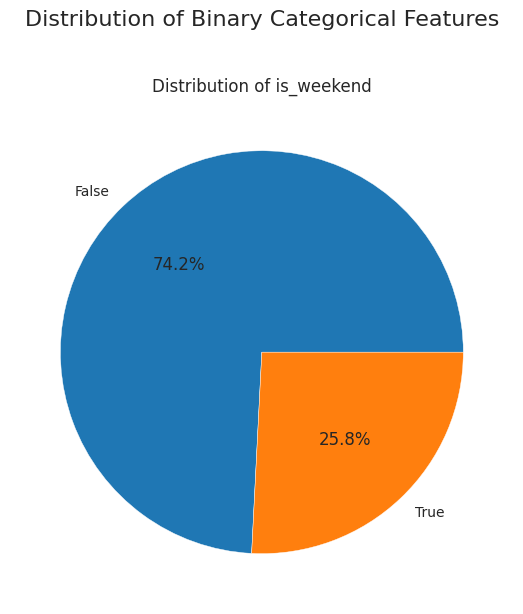

In [ ]:
plot_binary_distribution(df_final, ['is_weekend'])

In [ ]:
exp.logs['steps'] = {'exploration' : {
    'binary_distribution': dist
}}

In [26]:
df_base['start_station_name'].value_counts()
# Station identification presents high dimensionality, one-hot encoding will be applied
# using sklearn

KeyError: 'start_station_name'

In [ ]:
encoded_stations = one_hot_encode(df_base, 'start_station_name')
df_base.drop('start_station_name', axis=1, inplace=True)
df_base = pd.concat([df_base, encoded_stations], axis=1)

## Train

In [ ]:
setup = setup(
    data=df_final,
    target='trip_amount',
    numeric_features=['day', 'hour', 'avg_trip_duration', 'avg_trip_distance', 'member_ratio'],
    categorical_features=['weekday', 'is_weekend'],
    use_gpu = True,
    session_id=123)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,123
1,Target,trip_amount
2,Target type,Regression
3,Original data shape,"(744, 8)"
4,Transformed data shape,"(744, 14)"
5,Transformed train set shape,"(520, 14)"
6,Transformed test set shape,"(224, 14)"
7,Numeric features,5
8,Categorical features,2
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

In [ ]:
# Comparing different regression models
# choose only the tree based models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,184.1830,79545.2103,274.4194,0.9415,0.4703,0.4437,0.2980
et,Extra Trees Regressor,180.9286,77721.8701,273.9750,0.9411,0.4107,0.3920,0.3360
gbr,Gradient Boosting Regressor,202.2134,83587.5460,284.9188,0.9377,0.5619,0.5324,0.3690
rf,Random Forest Regressor,200.3989,97760.9435,302.2601,0.9269,0.4468,0.4362,0.4960
lightgbm,Light Gradient Boosting Machine,205.9997,99458.6535,301.1310,0.9257,0.5624,0.5166,0.1430
dt,Decision Tree Regressor,238.3577,154938.0885,384.7970,0.8839,0.4976,0.4431,0.1530
ada,AdaBoost Regressor,381.2976,215916.7966,461.5314,0.8385,0.9093,1.5350,0.2170
lasso,Lasso Regression,693.5979,721942.5146,849.2101,0.4513,1.1984,2.9371,0.1370
llar,Lasso Least Angle Regression,693.5979,721943.0245,849.2104,0.4513,1.1984,2.9371,0.1090
lr,Linear Regression,694.5536,722695.0015,849.6515,0.4505,1.2028,2.9540,0.1180


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
# Creating the best model found
best_model = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,263.8039,140157.6891,374.3764,0.8986,0.6506,0.7531
1,188.5135,87142.1897,295.1986,0.9325,0.5780,0.6516
2,196.6525,78387.2873,279.9773,0.9349,0.5156,0.3503
3,126.8566,30755.0750,175.3712,0.9768,0.3511,0.2780
4,168.9351,59662.9987,244.2601,0.9305,0.5277,0.5340
5,228.1012,158526.7297,398.1542,0.9032,0.5064,0.4570
6,140.1466,43140.4956,207.7029,0.9689,0.3121,0.2164
7,186.5561,74951.0640,273.7719,0.9553,0.4427,0.4279
8,175.6378,63187.5851,251.3714,0.9522,0.3656,0.2992


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Tuning the model for better performance
tuned_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,263.0932,181593.1860,426.1375,0.8686,0.6171,0.6265
1,184.6369,83044.7366,288.1748,0.9357,0.5619,0.5737
2,170.5202,58241.2761,241.3323,0.9517,0.3238,0.2355
3,137.7983,30046.4391,173.3391,0.9773,0.2979,0.2521
4,173.1811,53971.8840,232.3185,0.9371,0.5241,0.5516
5,214.5167,121578.4349,348.6810,0.9257,0.4453,0.4203
6,145.3195,51453.9320,226.8346,0.9629,0.3453,0.2650
7,163.5681,51990.1044,228.0134,0.9690,0.5752,0.3969
8,248.3524,129090.4050,359.2915,0.9023,0.4247,0.3451


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

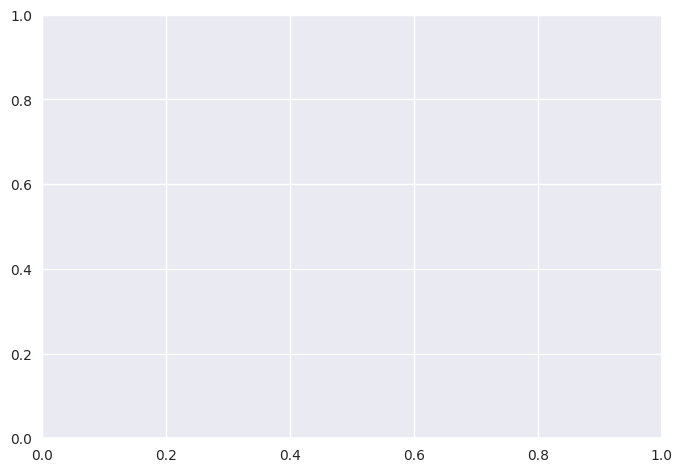

In [ ]:
# Evaluating the tuned model
evaluate_model(tuned_model)